# Support Vector Machine (SVM) Model

## Data Preprocessing

In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import random
import counting_fns as cf


# List of all the months
months = ['2_June', '3_July', '4_August', '5_September', '6_October']

# Define the path to the data directory and columns to keep
data_path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month"

## Randomized Months

In [5]:
# Randomly select 3 months for training set
# random.seed(350)
months_train = random.sample(months, 4)

# Print the months in the training set
print("Months in training set:", months_train)

# Create a list of remaining months for the test set
months_test = [month for month in months if month not in months_train]
# Print the months in the test set
print("Months in test set:", months_test)

Months in training set: ['6_October', '2_June', '5_September', '3_July']
Months in test set: ['4_August']


In [6]:
best_params = {'C': 10, 'kernel': 'rbf'}

## Load Dataframes

In [7]:
# Filter Columns
filter = ['session_time', 'gender', 'age_gen', 'day', 'timeofday', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet',
        'w/min', 'l/min', 'nh/min', 'd/min', '2ws_profit', '2ws_wgramt','2ws/min', 
        '3ws_profit', '3ws_wgramt', '3ws/min', '4ws_profit', '4ws_wgramt', '4ws/min', 
        'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'min_time_per_gamble', 'machines_changes', 'unique_machines', 'classification']

# Taking out ave_time_per_machine and max_time_per_gamble

# Load the datasets
datasets = cf.load_and_preprocess_datasets_ntop(months, data_path, 'session', filter)

# Create training and test sets
dt_train = pd.concat([datasets['dtf'+month[1:]] for month in months_train])
dt_test = pd.concat([datasets['dtf'+month[1:]] for month in months_test])

# # Seperate dependent and independent variables
X_train = dt_train.iloc[:, :-1].values
y_train = dt_train.iloc[:, -1].values
X_test = dt_test.iloc[:, :-1].values
y_test = dt_test.iloc[:, -1].values

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender
X_train[:, 0] = le.fit_transform(X_train[:, 0])
X_test[:, 0] = le.fit_transform(X_test[:, 0])


# # Encode age_generartion, day, time of day,  and time of day columns, first_outcome, and last_outcome.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.transform(X_test))

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# # Feature Scaling
sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 25:] = sc.fit_transform(X_train[:, 25:])
X_test[:, 25:] = sc.transform(X_test[:, 25:])

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

classifier = SVC(random_state = 0, **best_params)
classifier.fit(X_train_resample, y_train_resample)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

[[9664 1042]
 [ 343  951]]
Accuracy:  0.8845833333333334
Precision:  0.7214470442692122
Recall:  0.8188009237189795
F1 Score:  0.755888460179217


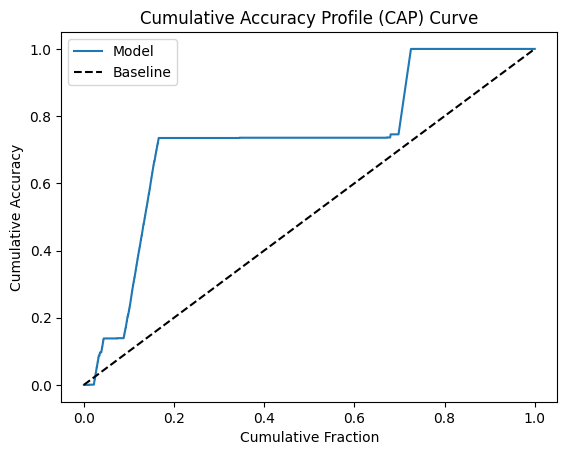

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()